# Imports

In [1]:
# imports

import os, sys
import numpy as np
import SimpleITK as sitk

from helpers_general import sitk2np, np2sitk, print_sitk_info, round_tuple, lrange, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs
from helpers_metrics import compute_dice_coefficient, compute_coverage_coefficient
from helpers_viz import viz_axis

In [2]:
# auto-reload when local helper fns change
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Data

In [3]:
# Data path

PROJ_PATH = "."

# Folders containing MR train data
train_path = f"{PROJ_PATH}/train_data/train_data"
train_data_dict = get_data_dict(train_path)

# print train data dict
print(f"Train data folders: {numbers2groups(sorted([int(x) for x in os.listdir(train_path)]))}")
print(f"Training data: key = train folder, value = full path to (segm obj, nii file)\n")

Train data folders: [range(50002, 50017), range(50019, 50020), 50049, range(50455, 50464)]
Training data: key = train folder, value = full path to (segm obj, nii file)



### Atlas

In [4]:
# Load atlas: atlas MRs (10 MRs labelled by Dr. Hollon, need nii LPS=>RAS adjustment)

atlas_range, ras_adj = range(50455, 50464), True
atlas_folders = [str(i) for i in atlas_range]
atlas_objs, atlas_mask_objs = zip(*[folder2objs(atlas_folder, train_data_dict, ras_adj) \
                               for atlas_folder in atlas_folders])

### Input

In [5]:
# Load input: set input MRs (Samir's, no RAS adj needed for mask)

input_range, ras_adj = range(50002, 50017), False
input_folders = [str(i) for i in input_range]
input_objs, input_mask_objs = zip(*[folder2objs(input_folder, train_data_dict, ras_adj) \
                               for input_folder in input_folders])

### Crop to Foreground

In [6]:
def lmap(fn, arr, unpack_input=False, unpack_output=False):
    output = [fn(*o) for o in arr] if unpack_input else [fn(o) for o in arr]
    return zip(*output) if unpack_output else output

In [7]:
# Crop https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
def threshold_based_crop(image, mask):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.  
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return (sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)]), \
            sitk.RegionOfInterest(mask, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)]))

In [8]:
cropped_atlas_objs, cropped_atlas_mask_objs = lmap(threshold_based_crop, zip(atlas_objs, atlas_mask_objs), unpack_input=True, unpack_output=True)
cropped_input_objs, cropped_input_mask_objs = lmap(threshold_based_crop, zip(input_objs, input_mask_objs), unpack_input=True, unpack_output=True)

In [9]:
idx = 0
print("Cropped Atlas", cropped_atlas_objs[idx].GetSize(), "Original", atlas_objs[idx].GetSize())
print("Cropped Input", cropped_input_objs[idx].GetSize(), "Original", input_objs[idx].GetSize())

Cropped Atlas (146, 422, 331) Original (160, 480, 512)
Cropped Input (165, 200, 206) Original (176, 256, 256)


### Resample to Standard Reference Domain

In [10]:
img_data = [(o.GetSize(), o.GetSpacing()) for o in cropped_atlas_objs + cropped_input_objs]
img_data

[((146, 422, 331), (1.1999999284744263, 0.5, 0.5)),
 ((147, 422, 347), (1.1999999284744263, 0.5, 0.5)),
 ((141, 411, 354), (1.2000000476837158, 0.5, 0.5)),
 ((137, 402, 348), (1.2000000476837158, 0.5, 0.5)),
 ((136, 404, 331), (1.2000000476837158, 0.5, 0.5)),
 ((145, 408, 310), (1.2000000476837158, 0.5, 0.5)),
 ((138, 371, 331), (1.2000000476837158, 0.5, 0.5)),
 ((139, 401, 367), (1.2000000476837158, 0.5, 0.5)),
 ((140, 413, 336), (1.2000000476837158, 0.5, 0.5)),
 ((165, 200, 206), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((163, 193, 203), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((167, 188, 195), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((154, 190, 197), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((154, 189, 178), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((153, 221, 206), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((162, 212, 200), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((166, 201, 213), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((1

In [11]:
# src: https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb

dimension = 3 # 3D MRs
pixel_id = 2 # 16-bit signed integer

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)

#img_data = [(o.GetSize(), o.GetSpacing()) for o in (cropped_atlas_obj, cropped_input_obj)]
for img_sz, img_spc in img_data:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                  for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]
    
# Create the reference image with a zero origin, identity direction cosine matrix and dimension     
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()


# Isotropic (1,1,1) pixels
reference_spacing = np.ones(dimension)
reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

# Set reference image attributes
reference_image = sitk.Image(reference_size, pixel_id)
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

In [12]:
reference_physical_size

array([174.30001187, 231.171875  , 225.91796875])

In [13]:
def resample(img, mask, interpolator = sitk.sitkLinear, default_intensity_value = 0.0):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(img, reference_image, centered_transform, interpolator, default_intensity_value), \
            sitk.Resample(mask, reference_image, centered_transform, sitk.sitkNearestNeighbor, default_intensity_value)

In [14]:
atlas_objs, atlas_mask_objs = lmap(resample, zip(cropped_atlas_objs, cropped_atlas_mask_objs), unpack_input=True, unpack_output=True)
input_objs, input_mask_objs = lmap(resample, zip(cropped_input_objs, cropped_input_mask_objs), unpack_input=True, unpack_output=True)

In [15]:
# atlas
atlas_mask_arrs   = lmap(sitk2np,  atlas_mask_objs)
atlas_bbox_coords = lmap(mask2bbox, atlas_mask_arrs)

# input
input_mask_arrs   = lmap(sitk2np,  input_mask_objs)
input_bbox_coords = lmap(mask2bbox, input_mask_arrs)

In [16]:
# atlas_objs, atlas_mask_objs = resampled_atlas_objs, resampled_atlas_mask_objs
# input_objs, input_mask_objs = resampled_input_objs, resampled_input_mask_objs

### Info

In [29]:
from pandas import DataFrame

unaligned_dices = [None] * (len(atlas_range) * len(input_range))
row = 0
for atlas_idx, atlas_mask_obj in enumerate(atlas_mask_objs):
    for input_idx, input_mask_obj in enumerate(input_mask_objs):
        dice = compute_dice_coefficient(sitk2np(input_mask_obj), sitk2np(atlas_mask_obj))
        unaligned_dices[row] = {"atlas": atlas_range[atlas_idx], 
                                 "input": input_range[input_idx],
                                 "unaligned_dice": dice}
        row += 1
        #print(f"Unaligned dice: {orig_dice:.3f}")
unaligned_dices = DataFrame(unaligned_dices)
unaligned_dices

,atlas,input,unaligned_dice
0,50455,50002,0.0
1,50455,50003,0.0
2,50455,50004,0.0
3,50455,50005,0.0
4,50455,50006,0.0
...,...,...,...
130,50463,50012,0.0
131,50463,50013,0.0
132,50463,50014,0.0
133,50463,50015,0.0


array([[<AxesSubplot:title={'center':'unaligned_dice'}>]], dtype=object)

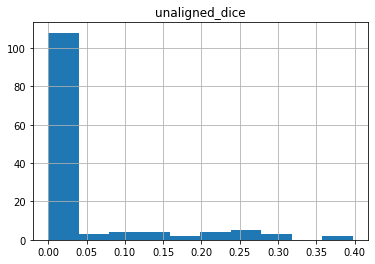

In [30]:
hist = unaligned_dices.hist(column="unaligned_dice")
hist

In [32]:
df = unaligned_dices.pivot(index="input", columns="atlas")
df['average'] = df.mean(numeric_only=True, axis=1)
df

unaligned_dice                                                  \
atlas          50455     50456     50457     50458 50459 50460 50461   
input                                                                  
50002            0.0  0.027459  0.034578  0.000000   0.0   0.0   0.0   
50003            0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   
50004            0.0  0.257906  0.263633  0.117738   0.0   0.0   0.0   
50005            0.0  0.035166  0.038441  0.000000   0.0   0.0   0.0   
50006            0.0  0.282255  0.275843  0.146643   0.0   0.0   0.0   
50007            0.0  0.093177  0.118848  0.033358   0.0   0.0   0.0   
50008            0.0  0.021592  0.029097  0.000000   0.0   0.0   0.0   
50009            0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   
50010            0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   
50011            0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   
50012            0.0  0.210140  0.240007  0.100309   0.0   0.0   0.0   
50013            0.0  0.150980  0.161567  0.027631   0.0   0.0   0.0   
50014            0.0  0.367202  0.397402  0.223556   0.0   0.0   0.0   
50015            0.0  0.244948  0.312422  0.139716   0.0   0.0   0.0   
50016            0.0  0.035049  0.040266  0.000000   0.0   0.0   0.0   

                        average  
atlas     50462 50463            
input                            
50002  0.000000   0.0  0.006893  
50003  0.000000   0.0  0.000000  
50004  0.180196   0.0  0.091053  
50005  0.000000   0.0  0.008179  
50006  0.205409   0.0  0.101128  
50007  0.059079   0.0  0.033829  
50008  0.000000   0.0  0.005632  
50009  0.000000   0.0  0.000000  
50010  0.000000   0.0  0.000000  
50011  0.000000   0.0  0.000000  
50012  0.136345   0.0  0.076311  
50013  0.068077   0.0  0.045362  
50014  0.297353   0.0  0.142835  
50015  0.200243   0.0  0.099703  
50016  0.000000   0.0  0.008368

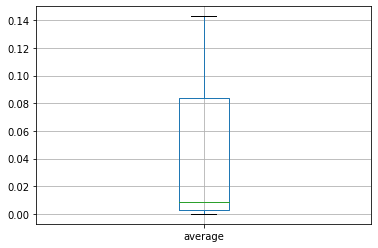

In [33]:
hist = df.boxplot(column="average")

### Physical info

In [23]:
def is_bbox(arr, imin, imax, jmin, jmax, kmin, kmax):
    return np.all(arr[imin:imax, jmin:jmax, kmin:kmax])

def get_info_df_row(folder, obj, mask_arr, bbox_coord):
    #print(bbox_coord)
    shape0, shape1, shape2             = obj.GetSize()
    imin, imax, jmin, jmax, kmin, kmax = bbox_coord
    roi_size0, roi_size1, roi_size2    = imax-imin, jmax-jmin, kmax-kmin
    is_bbox_bool                       = is_bbox(mask_arr, *bbox_coord)
    
    return {"folder": folder, \
            "shape0": shape0, "shape1": shape1, "shape2": shape2, \
            "roi_size0": roi_size0, "roi_size1": roi_size1, "roi_size2": roi_size2, \
            "is_bbox": is_bbox_bool,
            "imin": imin, "imax":imax, \
            "jmin":jmin, "jmax": jmax, \
            "kmin": kmin, "kmax": kmax}
    
def get_info_df(folders, objs, mask_arrs, bbox_coords):
    return DataFrame([get_info_df_row(folder, obj, mask_arr, bbox) \
                      for folder, obj, mask_arr, bbox in zip(folders, objs, mask_arrs, bbox_coords)])

In [24]:
atlas_info_df = get_info_df(atlas_range, atlas_objs, atlas_mask_arrs, atlas_bbox_coords)
atlas_info_df

,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50455,175,232,226,33,27,18,False,71,104,124,151,65,83
1,50456,175,232,226,30,24,16,False,70,100,126,150,85,101
2,50457,175,232,226,29,25,15,False,74,103,127,152,86,101
3,50458,175,232,226,25,23,19,False,74,99,126,149,79,98
4,50459,175,232,226,33,24,17,False,73,106,121,145,75,92
5,50460,175,232,226,29,27,15,False,74,103,124,151,66,81
6,50461,175,232,226,28,22,16,False,75,103,122,144,76,92
7,50462,175,232,226,31,24,16,False,72,103,126,150,83,99
8,50463,175,232,226,31,25,18,True,69,100,122,147,70,88


In [25]:
input_info_df = get_info_df(input_range, input_objs, input_mask_arrs, input_bbox_coords)
input_info_df

,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50002,175,232,226,38,28,21,False,74,112,130,158,101,122
1,50003,175,232,226,30,23,20,False,72,102,128,151,110,130
2,50004,175,232,226,36,28,26,False,68,104,125,153,95,121
3,50005,175,232,226,32,25,19,False,74,106,121,146,101,120
4,50006,175,232,226,30,25,20,False,72,102,121,146,95,115
5,50007,175,232,226,32,26,20,False,71,103,142,168,96,116
6,50008,175,232,226,30,23,18,False,75,105,137,160,101,119
7,50009,175,232,226,38,24,19,False,69,107,125,149,102,121
8,50010,175,232,226,25,21,17,False,79,104,121,142,104,121
9,50011,175,232,226,29,24,22,False,74,103,136,160,110,132


### Align

In [ ]:
# # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
# fixed_obj = resampled_input_obj
# moving_obj = resampled_atlas_obj

In [26]:
elastixImageFilter = sitk.ElastixImageFilter()

# set parameter map
param_folder = "ElastixParamFiles"
param_files = ["affine.txt"]

parameterMapVector = sitk.VectorOfParameterMap()
for param_file in param_files:
    parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
elastixImageFilter.SetParameterMap(parameterMapVector)

def atlas2pred(input_obj, atlas_obj, atlas_mask_obj):
    # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
    
    # input = fixed, atlas = moving
    elastixImageFilter.SetFixedImage(input_obj)
    elastixImageFilter.SetMovingImage(atlas_obj)
    elastixImageFilter.Execute()

    #pred_obj = elastixImageFilter.GetResultImage()

    # MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

    # set moving image (atlas)                                                    
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetMovingImage(atlas_mask_obj)

    # set parameter map (Binary mask => nearest neighbor final interpolation)
    transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
    transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

    # Execute transformation
    transformixImageFilter.Execute()
    
    pred_mask_obj = transformixImageFilter.GetResultImage()
    return pred_mask_obj

In [27]:
pred_mask_obj = atlas2pred(input_objs[0], atlas_objs[0], atlas_mask_objs[0])

In [36]:
print("Aligned1 Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), sitk2np(pred_mask_obj).astype(bool)));
print("Unaligned Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), sitk2np(atlas_mask_objs[0]).astype(bool)))

Aligned1 Dice:  0.6781862460860489
Unaligned Dice:  0.0


In [120]:
def halve(x): return (x+1)//2

def crop2roi(objs, bbox_coords, mult_factor=1):
    
    imin, imax, jmin, jmax, kmin, kmax = bbox_coords    
    sizes = [sz*mult_factor for sz in (imax-imin, jmax-jmin, kmax-kmin)]
    pads  = [halve(x) for x in sizes]
    
    # HACKY
    #pads = [30, 70, 70]
    
    imin_pad, jmin_pad, kmin_pad = [max(0, m-pad) for m,pad in zip((imin, jmin, kmin), pads)]
    imax_pad, jmax_pad, kmax_pad = [min(sz, m+pad) for m,pad,sz in zip((imax, jmax, kmax), pads, objs[0].GetSize())]
    
    
    return      (*[o[imin_pad:imax_pad, jmin_pad:jmax_pad, kmin_pad:kmax_pad] for o in objs], \
                (imin_pad, imax_pad, jmin_pad, jmax_pad, kmin_pad, kmax_pad))

In [121]:
cropped_atlas_obj, cropped_atlas_mask_obj, cropped_input_obj, cropped_input_mask_obj, cropped_bbox_coords = \
    crop2roi((atlas_objs[0], atlas_mask_objs[0], input_objs[0], input_mask_objs[0]), \
    mask2bbox(sitk2np(pred_mask_obj)), mult_factor=2)



In [122]:
print([o.GetSize() for o in (atlas_objs[0], pred_mask_obj, cropped_input_obj, cropped_atlas_obj, cropped_atlas_mask_obj)])

[(175, 232, 226), (175, 232, 226), (105, 93, 81), (105, 93, 81), (105, 93, 81)]


In [125]:
#print_bbox(*atlas_bbox_coords[0]); 
#print_bbox(*input_bbox_coords[0]); 
#print_bbox(*cropped_bbox_coords)
#print_bbox(*mask2bbox(sitk2np(cropped_input_mask_obj))); 

In [126]:
print_bbox(*mask2bbox(sitk2np(cropped_input_mask_obj)));
print_bbox(*input_bbox_coords[0])

Bbox coords: (35, 34, 35) to (73, 62, 56). Size: 38, 28, 21.
Bounding box coord: from location (34, 35) of slice 35 to location (62, 56) of slice 73.
Bbox coords: (74, 130, 101) to (112, 158, 122). Size: 38, 28, 21.
Bounding box coord: from location (130, 101) of slice 74 to location (158, 122) of slice 112.


In [127]:
pred_mask_obj2 = atlas2pred(cropped_input_obj, cropped_atlas_obj, cropped_atlas_mask_obj)

In [128]:
print(pred_mask_obj2.GetSize())

(105, 93, 81)


In [129]:
print_bbox(*input_bbox_coords[0])
print_bbox(*mask2bbox(sitk2np(pred_mask_obj)))
print_bbox(*mask2bbox(sitk2np(pred_mask_obj2)))

Bbox coords: (74, 130, 101) to (112, 158, 122). Size: 38, 28, 21.
Bounding box coord: from location (130, 101) of slice 74 to location (158, 122) of slice 112.
Bbox coords: (74, 127, 93) to (109, 158, 120). Size: 35, 31, 27.
Bounding box coord: from location (127, 93) of slice 74 to location (158, 120) of slice 109.
Bbox coords: (35, 32, 33) to (71, 65, 57). Size: 36, 33, 24.
Bounding box coord: from location (32, 33) of slice 35 to location (65, 57) of slice 71.


In [131]:
print("Aligned2 Dice: ", compute_dice_coefficient(sitk2np(cropped_input_mask_obj).astype(bool), sitk2np(pred_mask_obj2).astype(bool)));
print("Aligned1 Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), sitk2np(pred_mask_obj).astype(bool)));
print("Unaligned Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), sitk2np(atlas_mask_objs[0]).astype(bool)))

Aligned2 Dice:  0.7797426878041729
Aligned1 Dice:  0.6781862460860489
Unaligned Dice:  0.0


In [142]:
def get_offset(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin

def coords2pts(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin, imax, jmax, kmax

def pts2coords(coords):
    imin, jmin, kmin, imax, jmax, kmax = coords
    return imin, imax, jmin, jmax, kmin, kmax

def get_full_coords(cropped_bbox_coords, bbox_within):
    offset_pts  = get_offset(cropped_bbox_coords) * 2 # imin, jmin, kmin
    coords_pts  = coords2pts(bbox_within)
    return pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

def cascade2full_mask_arr(full_shape, full_bbox_coords, cascade_mask_arr, cascade_bbox_coords):
    full_arr = np.full(full_shape, False)
    
    imin, imax, jmin, jmax, kmin, kmax       = full_bbox_coords
    cimin, cimax, cjmin, cjmax, ckmin, ckmax = cascade_bbox_coords

    full_arr[imin:imax, jmin:jmax, kmin:kmax] = cascade_mask_arr[cimin:cimax, cjmin:cjmax, ckmin:ckmax]
    return full_arr

In [144]:
pred_mask_arr2 = sitk2np(pred_mask_obj2)
bbox_within = mask2bbox(pred_mask_arr2)
full_coords = get_full_coords(cropped_bbox_coords, bbox_within)
full_mask_arr = cascade2full_mask_arr(input_mask_arrs[0].shape, full_coords, pred_mask_arr2, bbox_within)

In [145]:
print("Full Aligned2 Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), full_mask_arr.astype(bool)));
print("Aligned2 Dice: ", compute_dice_coefficient(sitk2np(cropped_input_mask_obj).astype(bool), sitk2np(pred_mask_obj2).astype(bool)));
print("Aligned1 Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), sitk2np(pred_mask_obj).astype(bool)));
print("Unaligned Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), sitk2np(atlas_mask_objs[0]).astype(bool)))

Full Aligned2 Dice:  0.7781974914039421
Aligned2 Dice:  0.7797426878041729
Aligned1 Dice:  0.6781862460860489
Unaligned Dice:  0.0


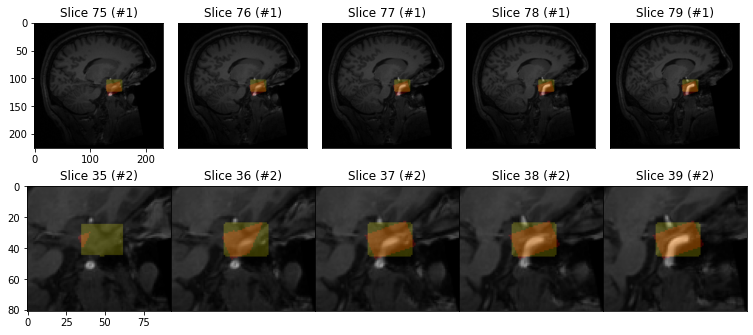

In [132]:
# viz
# Row 1 = full: pred1, input1
# Row 2 = cropped: pred2, input2
viz_axis(np_arr = sitk2np(input_objs[0]), \
        bin_mask_arr   = input_mask_arrs[0], color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = sitk2np(pred_mask_obj), color2 = "red", alpha2=0.3, \
        slices=lrange(75,80), fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = sitk2np(cropped_input_obj), \
        bin_mask_arr_b   = sitk2np(cropped_input_mask_obj), color1_b = "yellow", alpha1_b=0.3, \
        bin_mask_arr2_b  = sitk2np(pred_mask_obj2), color2_b = "red", alpha2_b=0.3, \
        slices_b = lrange(35,41), fixed_axis_b=0, \
        axis_fn_b = np.rot90, \
         
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [160]:
def cascaded_align_row(input_obj, input_mask_obj, atlas_objs=atlas_objs, atlas_mask_obj=atlas_mask_objs, mult_factor=2):
    
    dice_scores = {}
    n_votes = len(atlas_objs)
    print(f"N={n_votes} atlases in the vote.")
    
    input_mask_arr = sitk2np(input_mask_obj)
    
    for i in range(n_votes):
        print(f"Getting pred for atlas {i}:")
        
        pred_mask_obj1 = atlas2pred(input_obj, atlas_objs[i], atlas_mask_objs[i])
        pred_mask_arr1 = sitk2np(pred_mask_obj1)
        bbox = mask2bbox(pred_mask_arr1)
        
        print("aligned1")

        # crop given 1st ROI estimation
        cropped_atlas_obj, cropped_atlas_mask_obj, cropped_input_obj, cropped_input_mask_obj, cropped_bbox_coords = \
            crop2roi((atlas_objs[i], atlas_mask_objs[i], input_obj, input_mask_obj), bbox, mult_factor)
        
        # re-align
        pred_mask_obj2 = atlas2pred(cropped_input_obj, cropped_atlas_obj, cropped_atlas_mask_obj)
        pred_mask_arr2 = sitk2np(pred_mask_obj2)
        
        print("aligned2")
        
        # compute dice
        dice1 = compute_dice_coefficient(input_mask_arr, pred_mask_arr1)
        dice2 = compute_dice_coefficient(sitk2np(cropped_input_mask_obj), pred_mask_arr2)
        
        # save dice
        dice_scores[f"dice{i}"]     = dice1
        dice_scores[f"csc_dice{i}"] = dice2
    
        # add atlas vote
        
        # convert pred_mask_arr2 to full (for voting, need standard size)
        bbox_within = mask2bbox(pred_mask_arr2)
        full_coords = get_full_coords(cropped_bbox_coords, bbox_within)
        full_mask_arr2 = cascade2full_mask_arr(input_mask_arr.shape, full_coords, pred_mask_arr2, bbox_within)
            
        if i == 0:
            vote_pred_mask_arr1 = pred_mask_arr1.astype(np.uint8)
            vote_pred_mask_arr2 = full_mask_arr2.astype(np.uint8)
            
        else: 
            vote_pred_mask_arr1 += pred_mask_arr1.astype(np.uint8)
            vote_pred_mask_arr2 += full_mask_arr2.astype(np.uint8)

    # get avg dice score
    dice_scores[f"dice_avg"] = np.mean([v for k,v in dice_scores.items() if not k.startswith("csc")])
    dice_scores[f"csc_dice_avg"] = np.mean([v for k,v in dice_scores.items() if k.startswith("csc")])
    
    # get vote
    print(f"Getting vote dice")
    vote_pred_mask_arr1 = (vote_pred_mask_arr1 >= n_votes/2).astype(bool)
    vote_pred_mask_arr2 = (vote_pred_mask_arr2 >= n_votes/2).astype(bool)
    
    dice_scores[f"dice_vote_all"]     = compute_dice_coefficient(input_mask_arr, vote_pred_mask_arr1)
    dice_scores[f"csc_dice_vote_all"] = compute_dice_coefficient(input_mask_arr, vote_pred_mask_arr2)
    
    #print(dice_scores)
    return dice_scores

In [ ]:
return la ba sa ca da fa ta ye

In [153]:
test_row = cascaded_align_row(input_objs[0], input_mask_objs[0], atlas_objs[:2], atlas_mask_objs[:2], mult_factor=2)

N=2 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting vote dice
{'dice0': 0.6781862460860489, 'csc_dice0': 0.7797426878041729, 'dice1': 0.6682258603407952, 'csc_dice1': 0.6716267012313675, 'dice_avg': 0.6732060532134221, 'csc_dice_avg': 0.7256846945177702, 'dice_vote_all': 0.7245070670213, 'csc_dice_vote_all': 0.8198570043079144}


In [155]:
test_df = DataFrame([test_row])
test_df

,dice0,csc_dice0,dice1,csc_dice1,dice_avg,csc_dice_avg,dice_vote_all,csc_dice_vote_all
0,0.678186,0.779743,0.668226,0.671627,0.673206,0.725685,0.724507,0.819857


In [157]:
cols = test_df.columns.tolist()
csc_cols = [c for c in cols if c.startswith("csc")]
non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]

In [158]:
test_df[csc_cols]

,csc_dice0,csc_dice1,csc_dice_avg,csc_dice_vote_all
0,0.779743,0.671627,0.725685,0.819857


In [159]:
test_df[non_csc_cols]

,dice0,dice1,dice_avg,dice_vote_all
0,0.678186,0.668226,0.673206,0.724507


In [169]:
input_rows = [None] * len(input_range)
for i in range(len(input_range)):
    print(f"Row {i}: {input_range[i]}")
    
    try:
        input_rows[i] = cascaded_align_row(input_objs[i], input_mask_objs[i], atlas_objs, atlas_mask_objs, mult_factor=2)
    
        df = DataFrame([input_rows[i]])
        cols = df.columns.tolist()
        csc_cols = [c for c in cols if c.startswith("csc")]
        non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]

        display(df[non_csc_cols])
        display(df[csc_cols])
        
    except Exception as e:
        pass
        #print("Message:\n ", e.message, "\n", "Args:\n ", e.args)
        

Row 0: 50002
N=9 atlases in the vote.


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.678186,0.668226,0.685368,0.685387,0.562789,0.501625,0.485596,0.58001,0.687706,0.614988,0.631478


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.779743,0.671627,0.579602,0.663763,0.613792,0.621119,0.573089,0.641928,0.684027,0.647632,0.649206


Row 1: 50003
N=9 atlases in the vote.
Row 2: 50004
N=9 atlases in the vote.


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.659506,0.633646,0.594588,0.62733,0.673344,0.606199,0.640773,0.661992,0.72422,0.646844,0.645412


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.72047,0.661992,0.639817,0.697305,0.623527,0.549537,0.588431,0.597975,0.727565,0.64518,0.63378


Row 3: 50005
N=9 atlases in the vote.
Row 4: 50006
N=9 atlases in the vote.


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.521236,0.692351,0.614088,0.590081,0.774078,0.564709,0.751085,0.628112,0.733372,0.652124,0.675706


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.497317,0.738338,0.732572,0.685716,0.788737,0.440139,0.809693,0.676679,0.721368,0.676729,0.714471


Row 5: 50007
N=9 atlases in the vote.


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.73649,0.861922,0.795773,0.803387,0.793579,0.754082,0.670772,0.811099,0.855541,0.78696,0.855188


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.0,0.561849,0.560409,0.884125,0.0,0.0,0.5044,0.53939,0.0,0.338908,0.263738


Row 6: 50008
N=9 atlases in the vote.
Row 7: 50009
N=9 atlases in the vote.


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.111895,0.52952,0.533747,0.333393,0.300587,0.0,0.357487,0.462691,0.72264,0.37244,0.382489


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.289582,0.824659,0.808896,0.770631,0.767762,0.0,0.757557,0.768889,0.033862,0.557982,0.722943


Row 8: 50010
N=9 atlases in the vote.


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.004335,0.34972,0.46665,0.347063,0.014156,0.0,0.101582,0.197893,0.444986,0.214043,0.196284


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.509892,0.672938,0.788747,0.659952,0.0,0.704486,0.74509,0.63608,0.73606,0.605916,0.751477


Row 9: 50011
N=9 atlases in the vote.
Row 10: 50012
N=9 atlases in the vote.


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.0,0.152733,0.392369,0.380809,0.0,0.0,0.176215,0.135832,0.056641,0.143844,0.150005


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.275698,0.019041,0.715382,0.686988,0.087816,0.093559,0.763258,0.668058,0.083061,0.376985,0.304729


Row 11: 50013
N=9 atlases in the vote.
Row 12: 50014
N=9 atlases in the vote.


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.627312,0.747565,0.811982,0.641168,0.728723,0.556309,0.667381,0.679791,0.81421,0.69716,0.742948


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.751315,0.798151,0.853709,0.755084,0.73917,0.779483,0.728989,0.77905,0.711956,0.766323,0.837659


Row 13: 50015
N=9 atlases in the vote.


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.526162,0.450381,0.539332,0.430049,0.348105,0.059315,0.539316,0.415541,0.742774,0.450108,0.468395


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.441262,0.713521,0.747679,0.797392,0.701194,0.0,0.784564,0.671377,0.855398,0.63471,0.696247


Row 14: 50016
N=9 atlases in the vote.


In [ ]:
for i,test_row in enumerate(input_rows):
    print(f"Row {i}: {input_range[i]}")
    
    df = DataFrame([test_row])
    cols = df.columns.tolist()
    csc_cols = [c for c in cols if c.startswith("csc")]
    non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]
    
    display(df[non_csc_cols])
    display(df[csc_cols])

In [161]:
input_df = DataFrame(cascaded_align_row(input_obj, input_mask_obj, atlas_objs, atlas_mask_objs, mult_factor=2)
                     for input_obj, input_mask_obj in zip(input_objs, input_mask_objs))

N=9 atlases in the vote.
N=9 atlases in the vote.


RuntimeError: Exception thrown in SimpleITK ElastixImageFilter_Execute: /home/francesco/SimpleElastix/Code/Elastix/src/sitkElastixImageFilterImpl.cxx:259:
sitk::ERROR: 
itk::ExceptionObject (0x43d8f90)
Location: "unknown" 
File: /home/francesco/SimpleElastix/build/Elastix/Core/Main/elxElastixFilter.hxx
Line: 253
Description: itk::ERROR: ElastixFilter(0x404d3c0): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



In [ ]:
cols = input_df.columns.tolist()
csc_cols = [c for c in cols if c.startswith("csc")]
non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]

In [ ]:
input_df[csc_cols]

In [ ]:
input_df[non_csc_cols]

In [ ]:
def reorder_cols(df):
    cols = df.columns.tolist()
    csc = [c for c in cols if c.startswith("csc") and c]
    noncsc  = csc = [c for c in cols if not c.startswith("csc")]

In [ ]:
# pred_objs, pred_mask_objs = lmap(atlas2pred, zip(resampled_atlas_objs, resampled_atlas_mask_objs, resampled_input_objs), unpack_input=True)

In [ ]:
def get_offset(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin

def coords2pts(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin, imax, jmax, kmax

def pts2coords(coords):
    imin, jmin, kmin, imax, jmax, kmax = coords
    return imin, imax, jmin, jmax, kmin, kmax

#### H_0 Null

Align Atlas ROI + pad to full Input


In [ ]:
# imagine I have bbox within aligned loc (5,10,20) to (10,35,76)
bbox_within = pts2coords((5,10,20,10,35,76))
print_bbox(*bbox_within)

In [ ]:
# test
offset_pts  = get_offset(cropped_bbox_coords) * 2 # imin, jmin, kmin
coords_pts  = coords2pts(bbox_within)
full_coords = pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

print_bbox(*full_coords);


In [ ]:
def get_full_coords(cropped_bbox_coords, bbox_within):
    offset_pts  = get_offset(cropped_bbox_coords) * 2 # imin, jmin, kmin
    coords_pts  = coords2pts(bbox_within)
    return pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

def cascade2full(full_shape, full_bbox_coords, cascade_mask_arr, cascade_bbox_coords):
    full_arr = np.full(full_shape, False)
    
    imin, imax, jmin, jmax, kmin, kmax       = full_bbox_coords
    cimin, cimax, cjmin, cjmax, ckmin, ckmax = cascade_bbox_coords

    full_arr[imin:imax, jmin:jmax, kmin:kmax] = cascade_mask_arr[cimin:cimax, cjmin:cjmax, ckmin:ckmax]
    return full_arr


In [ ]:
# Viz

# Row 1. Full atlas w/ full coords
# Row 2. Cropped atlas w/ crop coords

viz_axis(np_arr = sitk2np(resampled_arr_objs[0]), \
        bin_mask_arr  = cascade_input_mask_arr, color1 = "yellow", alpha1=0.7, \
        bin_mask_arr2  = cascade_pred_mask_arr, color2 = "red", alpha2=0.7, \
        slices=cascade_input_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = cascade_pred_arr, \
        bin_mask_arr_b  = cascade_pred_mask_arr, color1_b = "yellow", alpha1_b=0.3,
        slices_b = cascade_pred_slice_range,
         
        np_arr_c = cascade_atlas_arr, \
        bin_mask_arr_c  = cascade_atlas_mask_arr, color1_c = "yellow", alpha1_c=0.3,
        slices_c = cascade_atlas_slice_range,
         
        grid = [3, 8], hspace=0.3, fig_mult=2)